# Operações com DataFrames

## Sobre os Dados
Neste notebook, estaremos trabalhando com dois conjuntos de dados:
- Preço das ações do Facebook ao longo de 2018 (obtido usando o pacote `stock_analysis`).
- Dados meteorológicos diários para Nova York da API dos Centros Nacionais de Informação Ambiental (NCEI) da NOAA.

*Nota: O NCEI faz parte da Administração Nacional Oceânica e Atmosférica (NOAA) e, como você pode ver pela URL da API, este recurso foi criado quando o NCEI era chamado de NCDC. Se a URL deste recurso mudar no futuro, você pode procurar por "NCEI weather API" para encontrar a atualizada.*

## Contexto sobre os dados meteorológicos

Significados dos dados:
- `AWND`: velocidade média do vento
- `PRCP`: precipitação em milímetros
- `SNOW`: queda de neve em milímetros
- `SNWD`: profundidade de neve em milímetros
- `TMAX`: temperatura máxima diária em Celsius
- `TMIN`: temperatura mínima diária em Celsius

## Configuração

In [1]:
import numpy as np
import pandas as pd

weather = pd.read_csv('data/nyc_weather_2018.csv', parse_dates=['date'])
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01,PRCP,GHCND:US1CTFR0039,",,N,",0.0
1,2018-01-01,PRCP,GHCND:US1NJBG0015,",,N,",0.0
2,2018-01-01,SNOW,GHCND:US1NJBG0015,",,N,",0.0
3,2018-01-01,PRCP,GHCND:US1NJBG0017,",,N,",0.0
4,2018-01-01,SNOW,GHCND:US1NJBG0017,",,N,",0.0


In [2]:
fb = pd.read_csv('data/fb_2018.csv', index_col='date', parse_dates=True)
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


## Aritmética e estatísticas

Já vimos que podemos usar operadores matemáticos como `+` e `/` diretamente com dataframes. No entanto, também podemos usar métodos, que nos permitem especificar o eixo sobre o qual realizar o cálculo. Por padrão, isso é feito por coluna. Vamos calcular os escores Z para o volume negociado e ver os dias em que isso foi mais do que 3 desvios padrão da média:

In [3]:
fb.assign(
    abs_z_score_volume=lambda x:
    x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()
).query('abs_z_score_volume > 3')

,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


Podemos usar `rank()` e `pct_change()` para ver quais dias tiveram a maior mudança no volume negociado em relação ao dia anterior:

In [7]:
fb.assign(
    volume_pct_change=fb.volume.pct_change(),
    pct_change_rank=lambda x:
    x.volume_pct_change.abs().rank(ascending=False)
).nsmallest(5, 'pct_change_rank')

,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


12 de janeiro foi quando a notícia de que o Facebook mudou seu produto de feed de notícias para focar mais no conteúdo dos amigos dos usuários do que nas marcas que seguem. Dado que a publicidade do Facebook é um componente-chave de seu negócio (cerca de 89% em 2017), muitas ações foram vendidas e o preço caiu em pânico.

In [5]:
fb['2018-01-11':'2018-01-12']

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


Ao longo de 2018, o preço das ações do Facebook nunca teve uma baixa acima de $215:

In [8]:
(fb > 215).any()

open       True
high       True
low       False
close      True
volume     True
dtype: bool

Facebook's OHLC (open, high, low, and close) prices all had at least one day they were at $215 or less:

In [7]:
(fb > 215).all()

open      False
high      False
low       False
close     False
volume     True
dtype: bool

## Agrupamento (Binning)

Ao trabalhar com volume negociado, podemos estar interessados em faixas de volume em vez dos valores exatos. Nenhum dois dias têm o mesmo volume negociado:

In [10]:
(fb.volume.value_counts() > 1).sum()

0

Podemos usar `pd.cut()` para criar 3 faixas de volume negociado com intervalos iguais e nomeá-las. Em seguida, podemos trabalhar com categorias de baixo, médio e alto volume negociado:

In [12]:
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()

volume
low     240
med       8
high      3
Name: count, dtype: int64

Vamos verificar os dias com alto volume de negociação:

In [13]:
fb[volume_binned == 'high'].sort_values('volume', ascending=False)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


Em 25 de julho, o Facebook anunciou um crescimento de usuários decepcionante e as ações despencaram no after-hours (após o fechamento do mercado):

In [14]:
fb['2018-07-25':'2018-07-26']

,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


O escândalo da Cambridge Analytica estourou no sábado, 17 de março, então olhamos para a segunda-feira seguinte para os números.

In [15]:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


Como a maioria dos dias tem volumes semelhantes, mas alguns são muito grandes, temos faixas muito largas. A maior parte dos dados está no bin de baixo volume.

<Axes: title={'center': 'Volume diário negociado das ações do Facebook em 2018 (com bins)'}, ylabel='Volume negociado'>

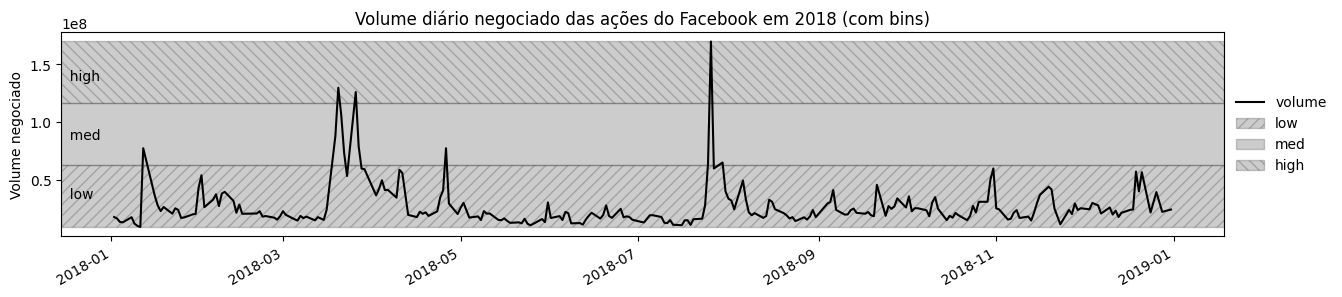

In [17]:
from visual_aids.misc_viz import low_med_high_bins_viz

low_med_high_bins_viz(
    fb, 'volume', ylabel='Volume negociado',
    title='Volume diário negociado das ações do Facebook em 2018 (com bins)'
)

Se dividirmos usando quantis, os bins terão aproximadamente o mesmo número de observações. Para isso, usaremos `qcut()`. Vamos criar 4 quartis:

In [18]:
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

volume
q1    63
q2    63
q4    63
q3    62
Name: count, dtype: int64

Note que os bins não cobrem mais intervalos de tamanho igual:

<Axes: title={'center': 'Volume diário negociado das ações do Facebook em 2018 (com bins de quartil)'}, ylabel='Volume negociado'>

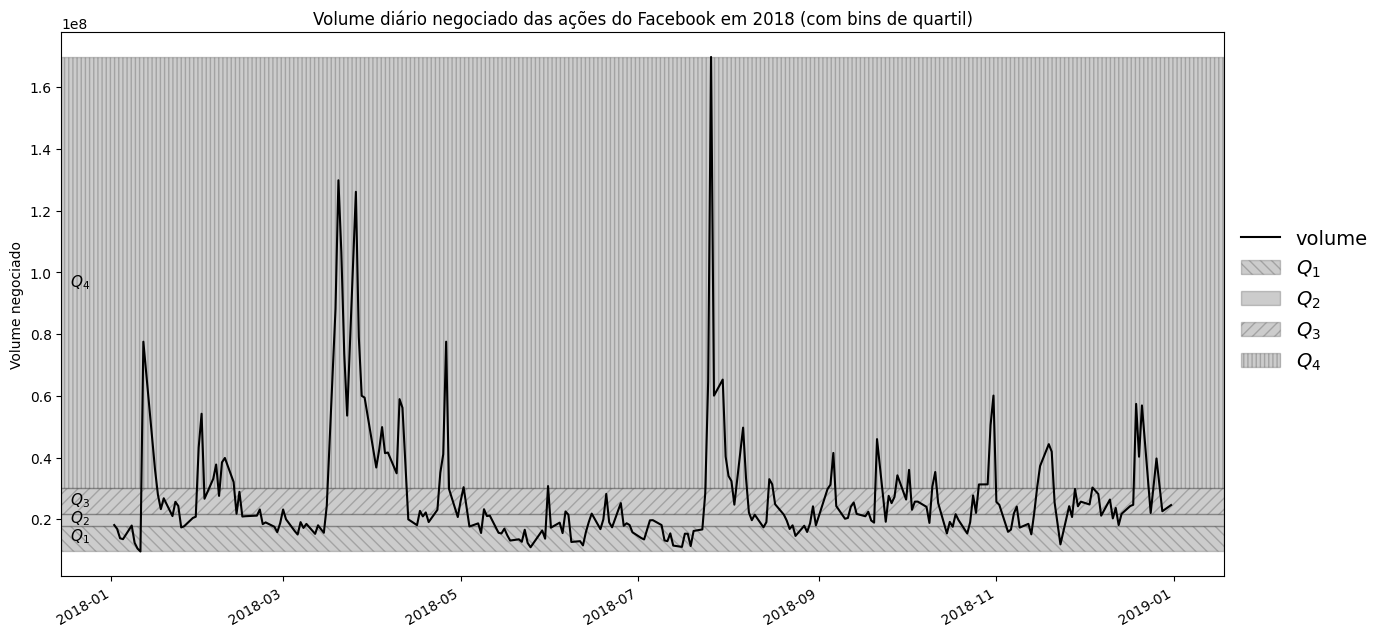

In [19]:
from visual_aids.misc_viz import quartile_bins_viz

quartile_bins_viz(
    fb, 'volume', ylabel='Volume negociado',
    title='Volume diário negociado das ações do Facebook em 2018 (com bins de quartil)'
)

## Aplicando Funções
Podemos usar o método `apply()` para executar a mesma operação em todas as colunas (ou linhas) do dataframe. Primeiro, vamos isolar as observações meteorológicas da estação Central Park e pivotar os dados:

In [21]:
central_park_weather = weather\
    .query('station == "GHCND:USW00094728"')\
    .pivot(index='date', columns='datatype', values='value')
central_park_weather.head()

datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT06,WT08
date,,,,,,,,,,,,,,,
2018-01-01,3.5,0.0,0.0,0.0,-7.1,-13.8,300.0,300.0,6.7,11.2,NaN,NaN,NaN,NaN,NaN
2018-01-02,3.6,0.0,0.0,0.0,-3.2,-10.5,260.0,250.0,7.2,12.5,NaN,NaN,NaN,NaN,NaN
2018-01-03,1.4,0.0,0.0,0.0,-1.0,-8.8,260.0,270.0,6.3,9.8,NaN,NaN,NaN,NaN,NaN
2018-01-04,5.6,19.3,249.0,30.0,-1.6,-7.1,310.0,310.0,10.7,19.2,1.0,1.0,NaN,NaN,1.0
2018-01-05,5.8,0.0,0.0,180.0,-7.1,-12.7,280.0,280.0,9.4,15.7,NaN,NaN,NaN,NaN,NaN


Vamos calcular os escores Z das observações de TMIN, TMAX e PRCP no Central Park em outubro de 2018:

In [23]:
oct_weather_z_scores = central_park_weather\
    .loc['2018-10', ['TMIN', 'TMAX', 'PRCP']]\
    .apply(lambda x: x.sub(x.mean()).div(x.std()))
oct_weather_z_scores.describe()

datatype,TMIN,TMAX,PRCP
count,3.100000e+01,3.100000e+01,3.100000e+01
mean,-1.790682e-16,1.951844e-16,4.655774e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.339112e+00,-1.305582e+00,-3.944384e-01
25%,-7.510188e-01,-8.700131e-01,-3.944384e-01
50%,-4.742689e-01,-1.382579e-01,-3.944384e-01
75%,1.065152e+00,1.011643e+00,-2.402528e-01
max,1.843511e+00,1.604016e+00,3.936167e+00


No dia 27 de outubro choveu muito mais do que nos outros dias.

In [24]:
oct_weather_z_scores.query('PRCP > 3').PRCP

date
2018-10-27    3.936167
Name: PRCP, dtype: float64

Realmente, este dia teve uma precipitação muito maior do que os outros.

In [25]:
central_park_weather.loc['2018-10', 'PRCP'].describe()

count    31.000000
mean      2.941935
std       7.458542
min       0.000000
25%       0.000000
50%       0.000000
75%       1.150000
max      32.300000
Name: PRCP, dtype: float64

## Cálculos de Janela
*Consulte o notebook [`understanding_window_calculations.ipynb`](./understanding_window_calculations.ipynb) para visualizações interativas usando widgets que ajudam a entender os cálculos de janela.*

O método `rolling()` nos permite realizar cálculos de janela deslizante. Simplesmente especificamos o tamanho da janela (3 dias aqui) e seguimos com uma chamada para uma função de agregação (soma aqui):

In [29]:
central_park_weather.loc['2018-10'].assign(
    rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7)

datatype,PRCP,rolling_PRCP
date,,
2018-10-01,0.0,0.0
2018-10-02,17.5,17.5
2018-10-03,0.0,17.5
2018-10-04,1.0,18.5
2018-10-05,0.0,1.0
2018-10-06,0.0,1.0
2018-10-07,0.0,0.0


Também podemos realizar os cálculos de janela deslizante em todo o dataframe de uma vez. Isso aplicará a mesma função de agregação a cada coluna:

In [30]:
central_park_weather.loc['2018-10'].rolling('3D').mean().head(7).iloc[:, :6]

datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
date,,,,,,
2018-10-01,0.900000,0.000000,0.0,0.0,24.400000,17.200000
2018-10-02,0.900000,8.750000,0.0,0.0,24.700000,17.750000
2018-10-03,0.966667,5.833333,0.0,0.0,24.233333,17.566667
2018-10-04,0.800000,6.166667,0.0,0.0,24.233333,17.200000
2018-10-05,1.033333,0.333333,0.0,0.0,23.133333,16.300000
2018-10-06,0.833333,0.333333,0.0,0.0,22.033333,16.300000
2018-10-07,1.066667,0.000000,0.0,0.0,22.600000,17.400000


Podemos usar funções de agregação diferentes por coluna se usarmos `agg()` em vez disso. Passamos um dicionário que mapeia a coluna para a agregação a ser realizada nela. Aqui, unimos o resultado aos dados originais para ver o que está acontecendo:

In [31]:
central_park_weather['2018-10-01':'2018-10-07'].rolling('3D').agg(
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join(  # join with original data for comparison
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
    lsuffix='_rolling'
).sort_index(axis=1)  # sort columns so rolling calcs are next to originals

datatype,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-06,0.5,0.833333,0.0,1.0,20.0,24.4,17.2,15.6
2018-10-07,1.1,1.066667,0.0,0.0,26.1,26.1,19.4,15.6


Suponha que tenhamos reindexado os dados das ações do Facebook, assim como fizemos com os dados do S&P 500 no capítulo 3. Se estivéssemos usando cálculos de janela deslizante nestes dados, estaríamos incluindo os valores nos dias em que o mercado estava fechado:

In [33]:
fb_reindexed = fb\
    .reindex(pd.date_range('2018-01-01', '2018-12-31', freq='D'))\
    .assign(
        volume=lambda x: x.volume.fillna(0),
        close=lambda x: x.close.ffill(),
        open=lambda x: x.open.combine_first(x.close),
        high=lambda x: x.high.combine_first(x.close),
        low=lambda x: x.low.combine_first(x.close)
    )
fb_reindexed.assign(day=lambda x: x.index.day_name()).head(10)

,open,high,low,close,volume,day
2018-01-01,NaN,NaN,NaN,NaN,0.0,Monday
2018-01-02,177.68,181.58,177.5500,181.42,18151903.0,Tuesday
2018-01-03,181.88,184.78,181.3300,184.67,16886563.0,Wednesday
2018-01-04,184.90,186.21,184.0996,184.33,13880896.0,Thursday
2018-01-05,185.59,186.90,184.9300,186.85,13574535.0,Friday
2018-01-06,186.85,186.85,186.8500,186.85,0.0,Saturday
2018-01-07,186.85,186.85,186.8500,186.85,0.0,Sunday
2018-01-08,187.20,188.90,186.3300,188.28,17994726.0,Monday
2018-01-09,188.70,188.80,187.1000,187.87,12393057.0,Tuesday
2018-01-10,186.94,187.89,185.6300,187.84,10529894.0,Wednesday


A partir da versão 1.0, o `pandas` suporta a definição de janelas personalizadas para cálculos de janela deslizante, o que nos permite realizar cálculos de janela deslizante nos dias em que o mercado estava aberto. Uma maneira de fazer isso é criar uma nova classe que herde de `BaseIndexer` e fornecer a lógica para determinar os limites da janela no método `get_window_bounds()` (mais informações [aqui](https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#custom-window-rolling)). Para nosso caso de uso, podemos usar a classe `VariableOffsetWindowIndexer`, que foi introduzida na versão 1.1, para realizar cálculos de janela deslizante com deslocamentos de tempo não fixos (como dias úteis). Vamos realizar um cálculo de janela deslizante de três dias úteis nos dados reindexados das ações do Facebook e unir com os dados reindexados para comparação:

In [34]:
from pandas.api.indexers import VariableOffsetWindowIndexer

indexer = VariableOffsetWindowIndexer(
    index=fb_reindexed.index, offset=pd.offsets.BDay(3)
)
fb_reindexed.assign(window_start_day=0).rolling(indexer).agg({
    'window_start_day': lambda x: x.index.min().timestamp(),
    'open': 'mean', 'high': 'max', 'low': 'min',
    'close': 'mean', 'volume': 'sum'
}).join(
    fb_reindexed, lsuffix='_rolling'
).sort_index(axis=1).assign(
    day=lambda x: x.index.day_name(),
    window_start_day=lambda x: pd.to_datetime(x.window_start_day, unit='s')
).head(10)

,close,close_rolling,high,high_rolling,low,low_rolling,open,open_rolling,volume,volume_rolling,window_start_day,day
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2018-01-01,Monday
2018-01-02,181.42,181.420000,181.58,181.58,177.5500,177.5500,177.68,177.680000,18151903.0,18151903.0,2018-01-01,Tuesday
2018-01-03,184.67,183.045000,184.78,184.78,181.3300,177.5500,181.88,179.780000,16886563.0,35038466.0,2018-01-01,Wednesday
2018-01-04,184.33,183.473333,186.21,186.21,184.0996,177.5500,184.90,181.486667,13880896.0,48919362.0,2018-01-02,Thursday
2018-01-05,186.85,185.283333,186.90,186.90,184.9300,181.3300,185.59,184.123333,13574535.0,44341994.0,2018-01-03,Friday
2018-01-06,186.85,186.010000,186.85,186.90,186.8500,184.0996,186.85,185.780000,0.0,27455431.0,2018-01-04,Saturday
2018-01-07,186.85,186.220000,186.85,186.90,186.8500,184.0996,186.85,186.047500,0.0,27455431.0,2018-01-04,Sunday
2018-01-08,188.28,186.632000,188.90,188.90,186.3300,184.0996,187.20,186.278000,17994726.0,45450157.0,2018-01-04,Monday
2018-01-09,187.87,187.340000,188.80,188.90,187.1000,184.9300,188.70,187.038000,12393057.0,43962318.0,2018-01-05,Tuesday
2018-01-10,187.84,187.538000,187.89,188.90,185.6300,185.6300,186.94,187.308000,10529894.0,40917677.0,2018-01-06,Wednesday


Os cálculos de janela deslizante (`rolling()`) utilizam uma janela deslizante. Por outro lado, os cálculos de expansão (`expanding()`) aumentam de tamanho. Esses são equivalentes a agregações cumulativas como `cumsum()`; no entanto, podemos especificar o número mínimo de períodos necessários para começar a calcular (o padrão é 1), e não estamos limitados a agregações predefinidas. Portanto, embora não haja um método para a média acumulada, podemos calculá-la usando `expanding()`. Vamos calcular a média de precipitação acumulada do mês até a data:

In [35]:
central_park_weather.loc['2018-06'].assign(
    TOTAL_PRCP=lambda x: x.PRCP.cumsum(),
    AVG_PRCP=lambda x: x.PRCP.expanding().mean()
).head(10)[['PRCP', 'TOTAL_PRCP', 'AVG_PRCP']]

datatype,PRCP,TOTAL_PRCP,AVG_PRCP
date,,,
2018-06-01,6.9,6.9,6.900000
2018-06-02,2.0,8.9,4.450000
2018-06-03,6.4,15.3,5.100000
2018-06-04,4.1,19.4,4.850000
2018-06-05,0.0,19.4,3.880000
2018-06-06,0.0,19.4,3.233333
2018-06-07,0.0,19.4,2.771429
2018-06-08,0.0,19.4,2.425000
2018-06-09,0.0,19.4,2.155556


Também podemos usar `agg()` para especificar agregações por coluna. Note que isso funciona com funções do NumPy também. Aqui, vamos unir os cálculos de expansão com os resultados originais para comparação:

In [45]:
central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join(
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
    lsuffix='_expanding'
).sort_index(axis=1)

datatype,AWND,AWND_expanding,PRCP,PRCP_expanding,TMAX,TMAX_expanding,TMIN,TMIN_expanding
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.825000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,0.980000,0.0,18.5,21.7,25.0,15.6,15.6
2018-10-06,0.5,0.900000,0.0,18.5,20.0,25.0,17.2,15.6
2018-10-07,1.1,0.928571,0.0,18.5,26.1,26.1,19.4,15.6


O Pandas fornece o método `ewm()` para cálculos de média móvel exponencialmente ponderada. Como vimos no capítulo 1, podemos usar a média móvel exponencialmente ponderada para suavizar os dados. Vamos comparar a média móvel simples com a média móvel exponencialmente ponderada da temperatura máxima diária. Note que `span` aqui são os períodos a serem utilizados:

In [37]:
central_park_weather.assign(
    AVG=lambda x: x.TMAX.rolling('30D').mean(),
    EWMA=lambda x: x.TMAX.ewm(span=30).mean()
).loc['2018-09-29':'2018-10-08', ['TMAX', 'EWMA', 'AVG']]

datatype,TMAX,EWMA,AVG
date,,,
2018-09-29,22.2,24.410887,24.723333
2018-09-30,21.1,24.197281,24.573333
2018-10-01,24.4,24.210360,24.533333
2018-10-02,25.0,24.261304,24.460000
2018-10-03,23.3,24.199285,24.163333
2018-10-04,24.4,24.212234,23.866667
2018-10-05,21.7,24.050154,23.533333
2018-10-06,20.0,23.788854,23.070000
2018-10-07,26.1,23.937960,23.143333


*Consulte o notebook [`understanding_window_calculations.ipynb`](./understanding_window_calculations.ipynb) para visualizações interativas que ajudam a entender os cálculos de janela.*

## Pipes
Os pipes são uma maneira de simplificar nosso código `pandas` e torná-lo mais legível e flexível. Usando pipes, podemos transformar uma chamada aninhada como

```python
f(g(h(data), 20), x=True)
```

em algo mais legível:

```python
data.pipe(h)\
    .pipe(g, 20)\
    .pipe(f, x=True)\
```

Podemos usar pipes para aplicar qualquer função que aceite nossos dados como primeiro argumento e passar quaisquer argumentos adicionais. Isso facilita encadear etapas juntas, independentemente de serem métodos ou funções:

Podemos passar qualquer função que aceite o chamador de `pipe()` como primeiro argumento:

In [38]:
def get_info(df):
    return '%d rows, %d columns and max closing Z-score was %d' % (*df.shape, df.close.max())


get_info(fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))\
    == fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)

True

Por exemplo, passar `pd.DataFrame.rolling` para `pipe()` é equivalente a chamar `rolling()` diretamente no dataframe, exceto que temos mais flexibilidade para alterar isso:

In [39]:
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())

True

O `pipe` pega a função passada e a chama com o objeto que chamou `pipe()` como primeiro argumento. Argumentos posicionais e de palavra-chave são passados para baixo:

In [40]:
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

True

Podemos usar um pipe para criar uma função que podemos utilizar para todas as nossas necessidades de cálculo de janela:

In [41]:
from window_calc import window_calc
window_calc??

Signature: window_calc(df, func, agg_dict, *args, **kwargs)
Source:   
def window_calc(df, func, agg_dict, *args, **kwargs):
    """
    Run a window calculation of your choice on a `DataFrame` object.
    
    Parameters:
        - df: The `DataFrame` object to run the calculation on.
        - func: The window calculation method that takes `df`
          as the first argument.
        - agg_dict: Information to pass to `agg()`, could be a
          dictionary mapping the columns to the aggregation
          function to use, a string name for the function,
          or the function itself.
        - args: Positional arguments to pass to `func`.
        - kwargs: Keyword arguments to pass to `func`.
    
    Returns:
        A new `DataFrame` object.
    """
    return df.pipe(func, *args, **kwargs).agg(agg_dict)
File:      ~/Documents/FIAP/Hands-On-Data-Analysis-with-Pandas-2nd-edition-pt-br/ch_04/window_calc.py
Type:      function

Podemos usar a mesma interface para calcular várias operações de janela agora. Vamos encontrar a mediana expandida para os dados do Facebook:

In [42]:
window_calc(fb, pd.DataFrame.expanding, np.median).head()

/Users/goliveira/Documents/FIAP/Hands-On-Data-Analysis-with-Pandas-2nd-edition-pt-br/ch_04/window_calc.py:22: FutureWarning: The provided callable <function median at 0x107563370> is currently using Expanding.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  return df.pipe(func, *args, **kwargs).agg(agg_dict)


,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.580,177.5500,181.420,18151903.0
2018-01-03,179.78,183.180,179.4400,183.045,17519233.0
2018-01-04,181.88,184.780,181.3300,184.330,16886563.0
2018-01-05,183.39,185.495,182.7148,184.500,15383729.5
2018-01-08,184.90,186.210,184.0996,184.670,16886563.0


Usar a média móvel exponencialmente ponderada requer que passemos um argumento de palavra-chave:

In [43]:
window_calc(fb, pd.DataFrame.ewm, 'mean', span=3).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.680000,181.580000,177.550000,181.420000,1.815190e+07
2018-01-03,180.480000,183.713333,180.070000,183.586667,1.730834e+07
2018-01-04,183.005714,185.140000,182.372629,184.011429,1.534980e+07
2018-01-05,184.384000,186.078667,183.736560,185.525333,1.440299e+07
2018-01-08,185.837419,187.534839,185.075110,186.947097,1.625679e+07


Com cálculos de janela deslizante, podemos passar um argumento posicional para o tamanho da janela:

In [44]:
window_calc(
    central_park_weather.loc['2018-10'],
    pd.DataFrame.rolling,
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'},
    '3D'
).head()

datatype,TMAX,TMIN,AWND,PRCP
date,,,,
2018-10-01,24.4,17.2,0.900000,0.0
2018-10-02,25.0,17.2,0.900000,17.5
2018-10-03,25.0,17.2,0.966667,17.5
2018-10-04,25.0,16.1,0.800000,18.5
2018-10-05,24.4,15.6,1.033333,1.0


<hr>
<div style="overflow: hidden; margin-bottom: 10px;">
    <div style="float: left;">
         <a href="./1-querying_and_merging.ipynb">
            <button>&#8592; Previous Notebook</button>
        </a>
        <a href="./understanding_window_calculations.ipynb">
            <button>Understanding Window Calculations</button>
        </a>
    </div>
    <div style="float: right;">
        <a href="./3-aggregations.ipynb">
            <button>Next Notebook &#8594;</button>
        </a>
    </div>
</div>
<hr>